# RAG with Recursive Abstractive Processing for Tree-Organized Retrival (RAPTOR)

In [2]:
import os
from dotenv import load_dotenv

load_dotenv('app/src/shared/.env')
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

## Document loaders - Load Sources

### Loading the pdf docs with PyPDF loader

In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from typing import List, Dict
import os
import logging
from concurrent.futures import ThreadPoolExecutor
from typing import List


# Configure logging 
logging.basicConfig(filename='pdf_processing.log', level=logging.INFO, format='%(asctime)s %(message)s')

# Função de carregamento de PDF
def load_pdf_file(pdf_folder_path: str, filename: str) -> List[Document]:
    """Processes a single PDF file and returns the extracted elements.

    Logs information and errors during processing.
    """
    try:
        pages = []
        loader = PyPDFLoader(os.path.join(pdf_folder_path, filename))
        pages = loader.load()
        logging.info(f"Successfully processed PDF: {filename}")
        return pages
    except Exception as e:  # Catch specific PDF processing errors
        logging.error(f"Error processing PDF: {filename} - {e}")
        return []
    
    # Função para processar múltiplos PDFs
def process_multiple_pdfs(pdf_folder_path: str, max_workers: int = 8) -> Dict[str, List]:
    """Processes all PDF files within a specified folder using ThreadPoolExecutor.

    Logs information and errors during processing.
    """
    all_elements = {}
    filenames = [filename for filename in os.listdir(pdf_folder_path) if filename.endswith(".pdf")]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Mapeando cada filename para a função load_pdf_file com a pasta de PDFs
        future_to_filename = {executor.submit(load_pdf_file, pdf_folder_path, filename): filename for filename in filenames}

        for future in future_to_filename:
            filename = future_to_filename[future]
            try:
                result = future.result()
                all_elements[filename] = result  # Armazenando o resultado no dicionário
            except Exception as e:
                logging.error(f"Error processing PDF: {filename} - {e}")
                all_elements[filename] = []

    return all_elements


pdf_folder_path = "app/src/database/pdf"
pdf_results = process_multiple_pdfs(pdf_folder_path)

for filename, elements in pdf_results.items():
    print(f"PDF: {filename}, Pages: {len(elements)}")

PDF: NBR_5419_1.pdf, Pages: 77
PDF: NBR_5419_3.pdf, Pages: 61
PDF: ABNT_NBR_IEC_60079_14.pdf, Pages: 94
PDF: NBR_5419_2.pdf, Pages: 116
PDF: NBR_5410.pdf, Pages: 217
PDF: NBR_5413.pdf, Pages: 13
PDF: NBR_5419_4.pdf, Pages: 99
PDF: NBR_14039.pdf, Pages: 102
PDF: NBR_13570.pdf, Pages: 5
PDF: NBR_10898.pdf, Pages: 44
PDF: NBR_15514.pdf, Pages: 30
PDF: NBR_16280.pdf, Pages: 17


## Visualization of the texts data

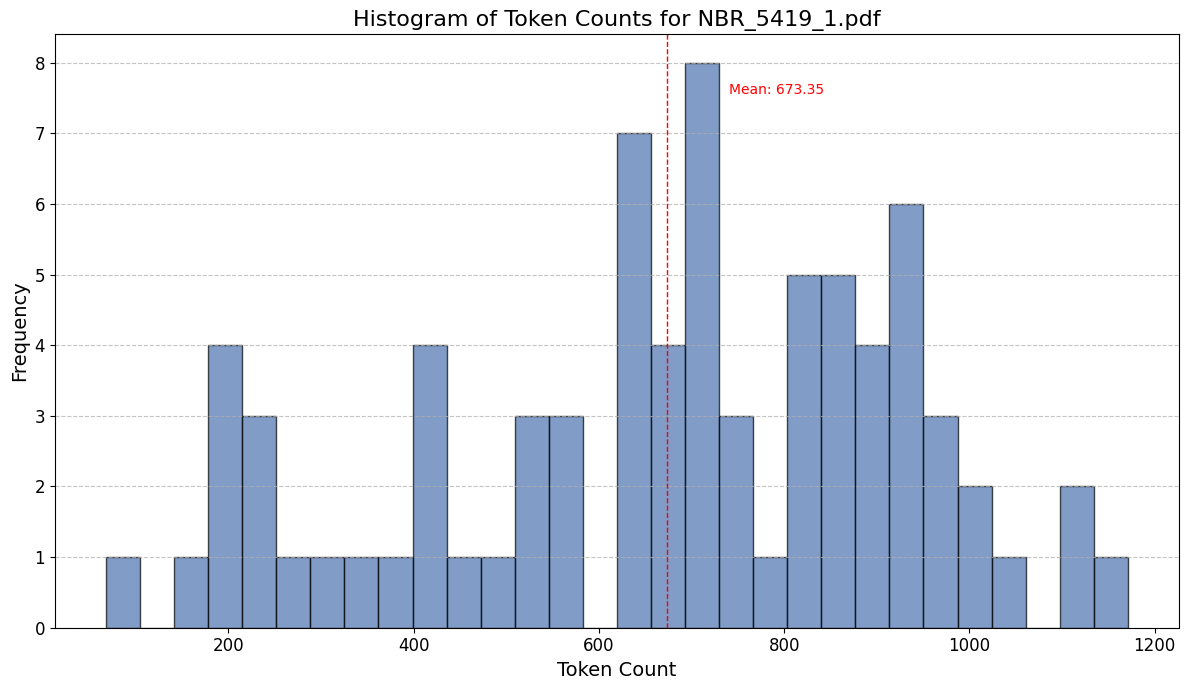

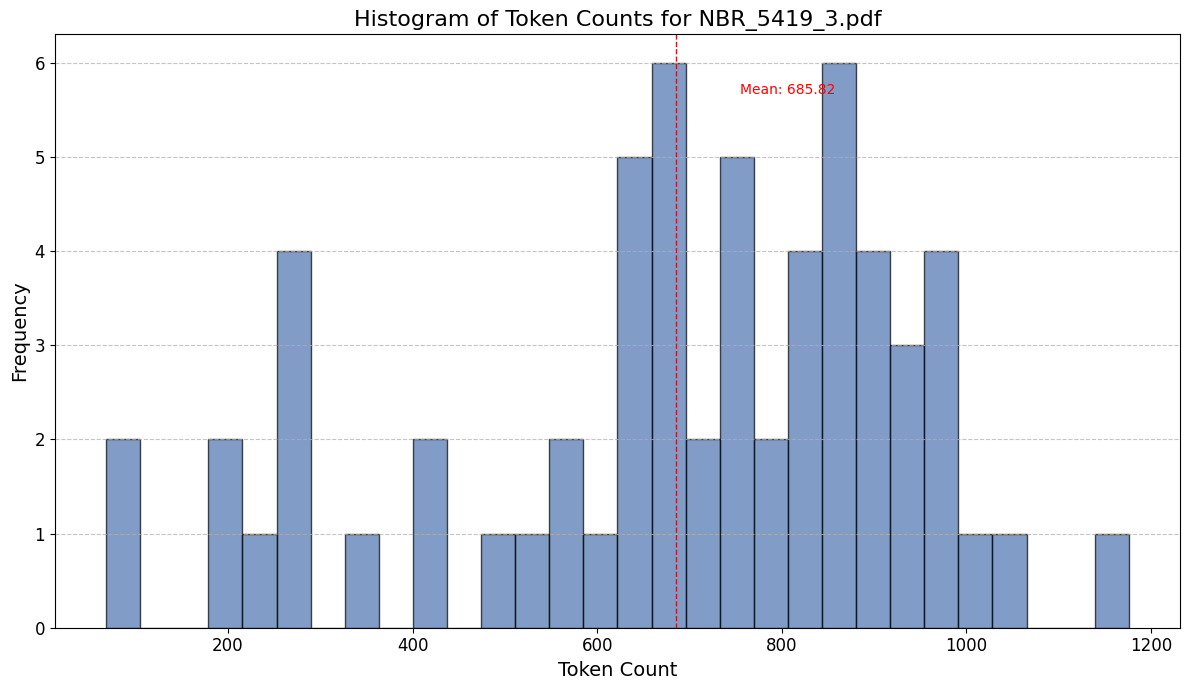

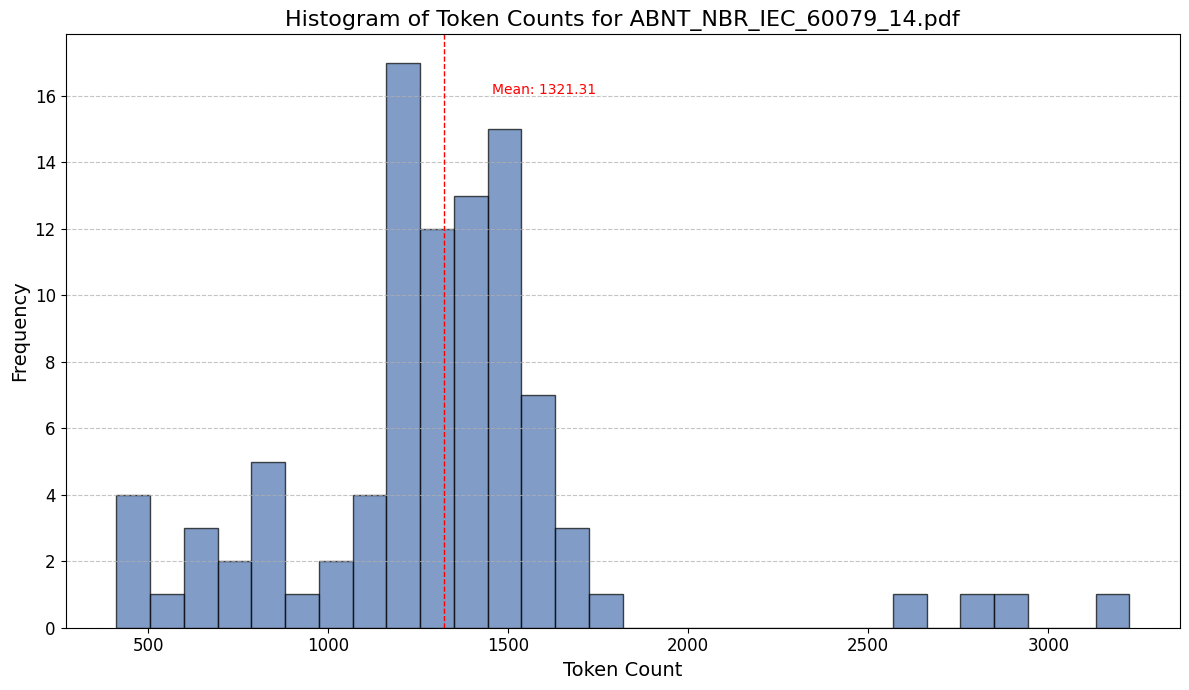

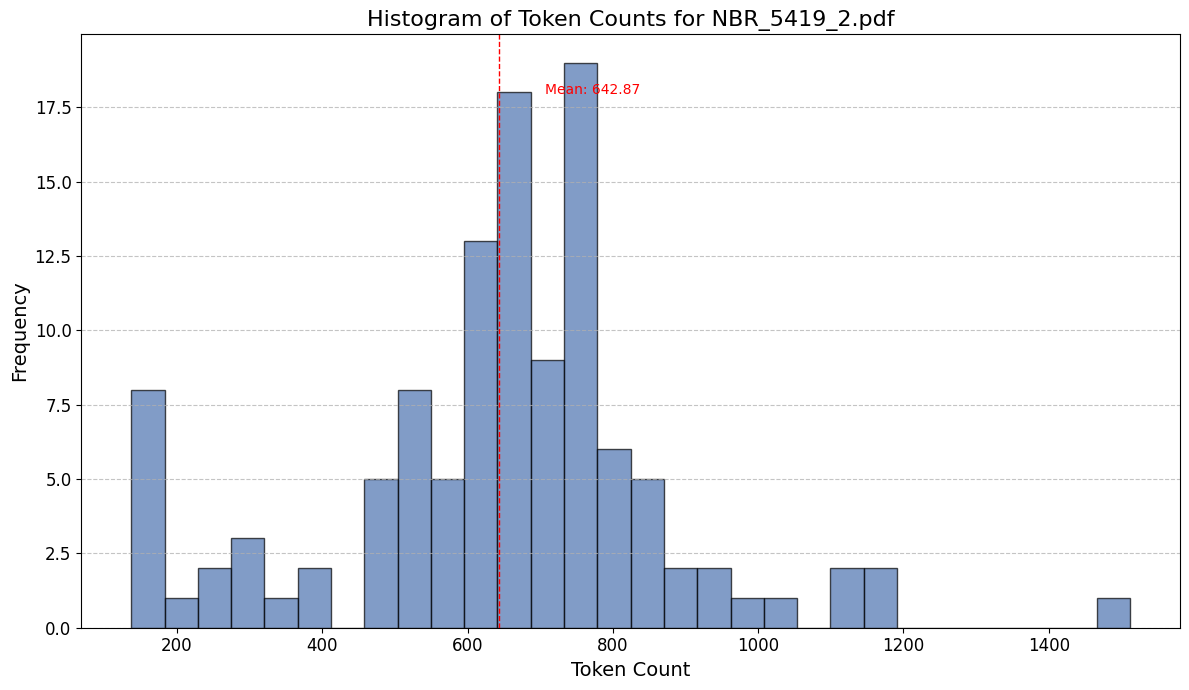

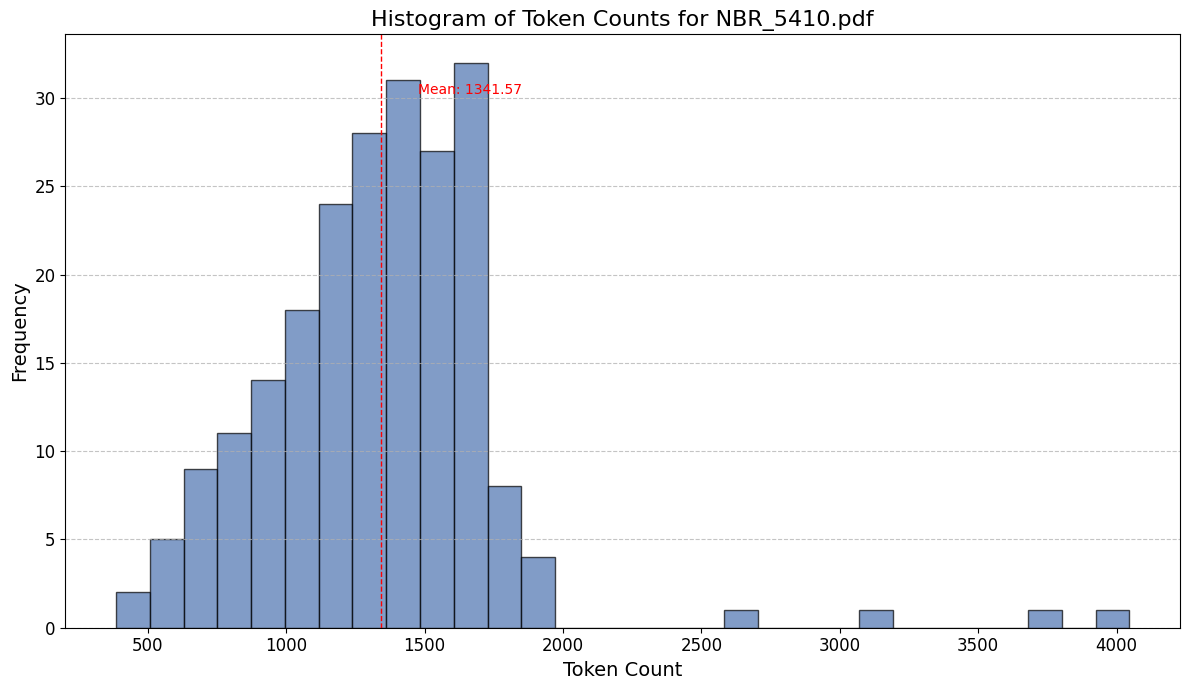

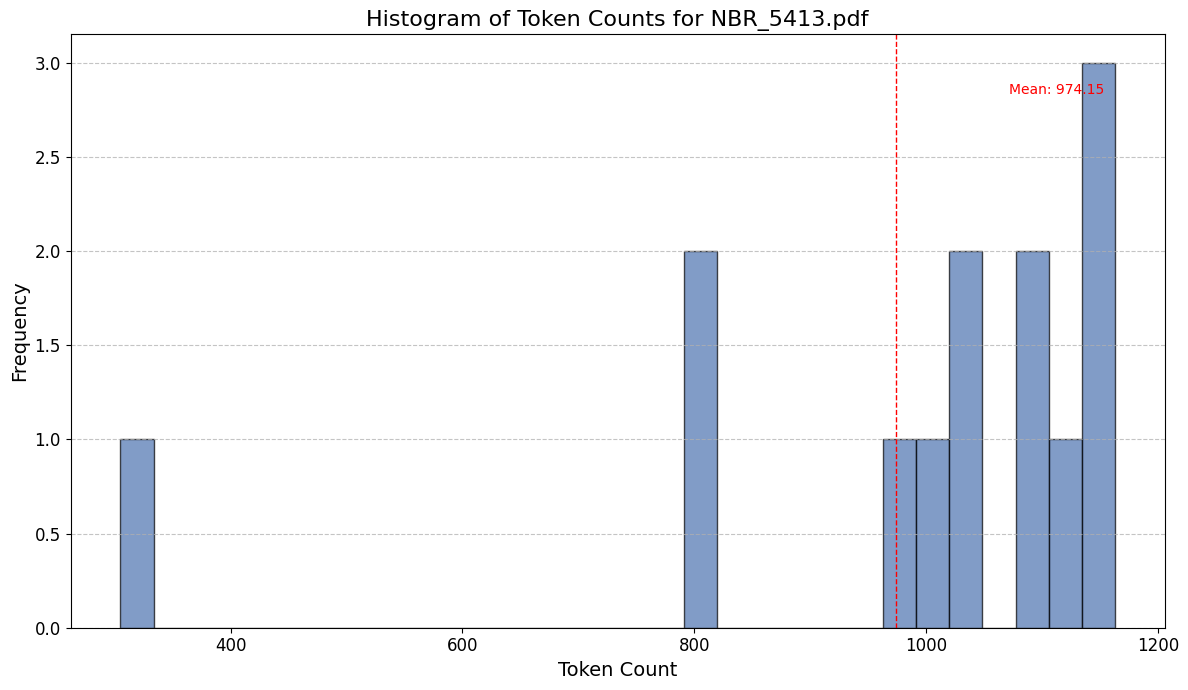

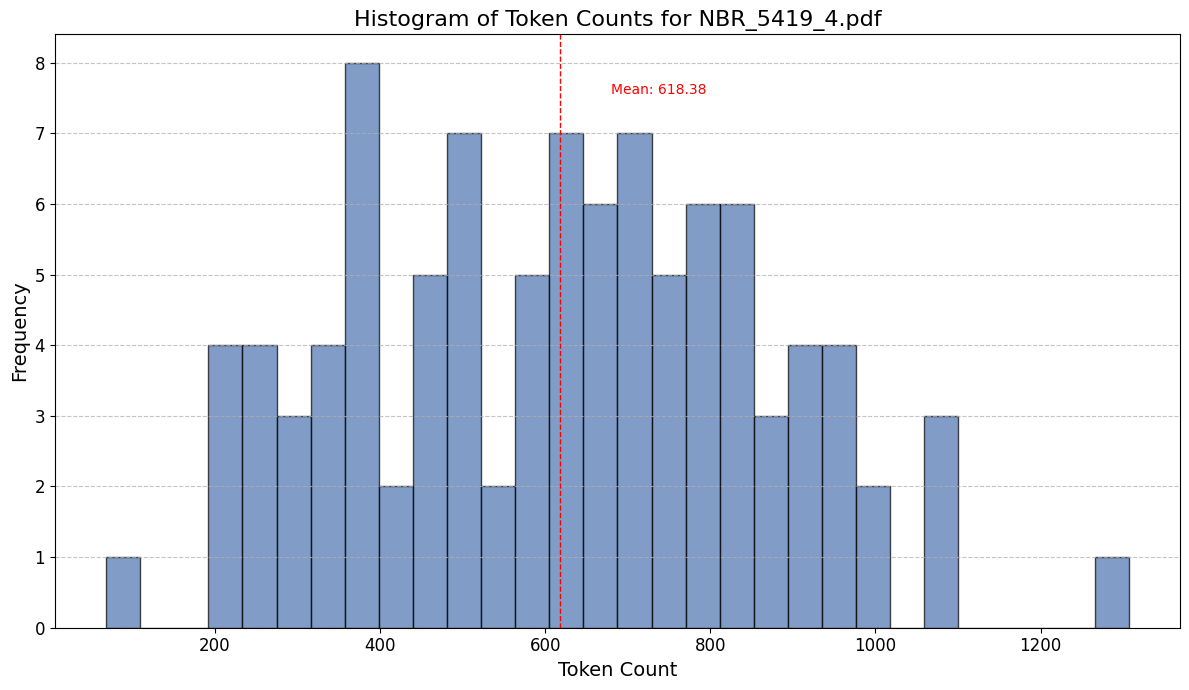

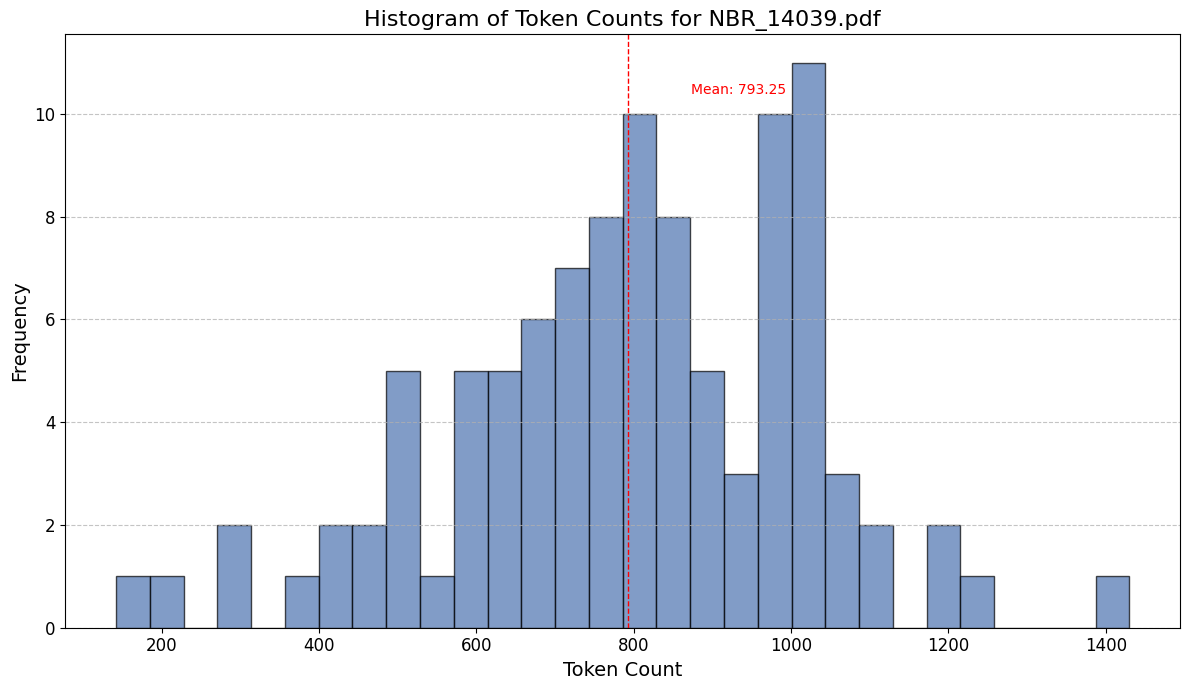

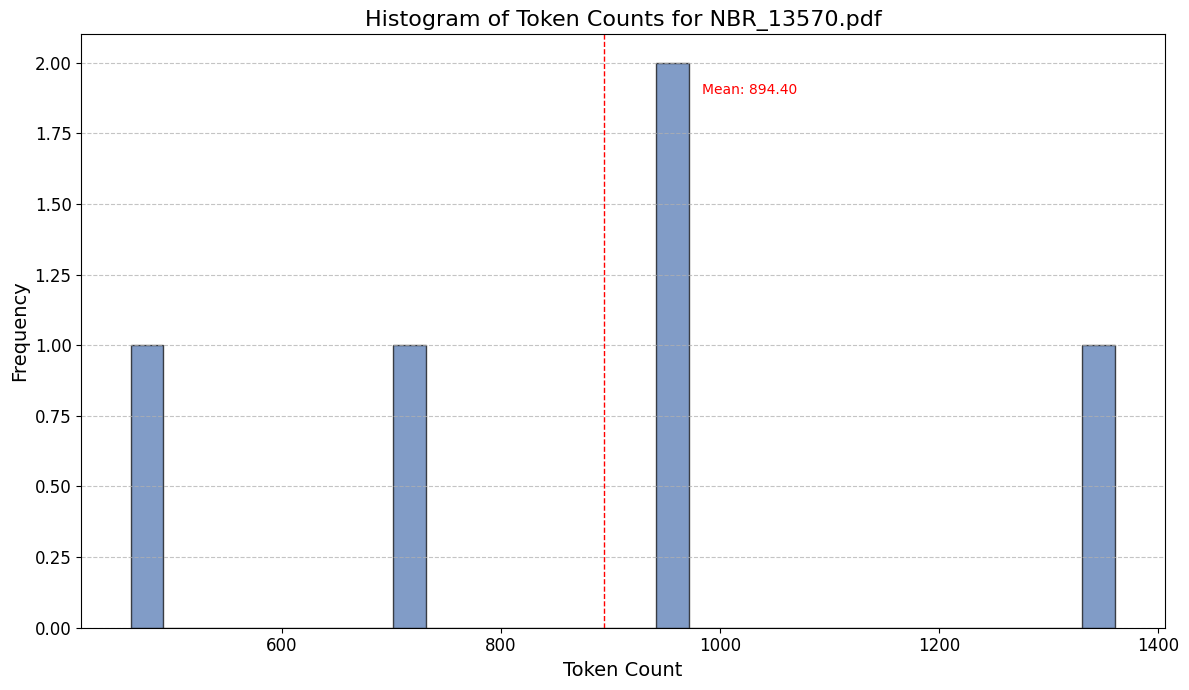

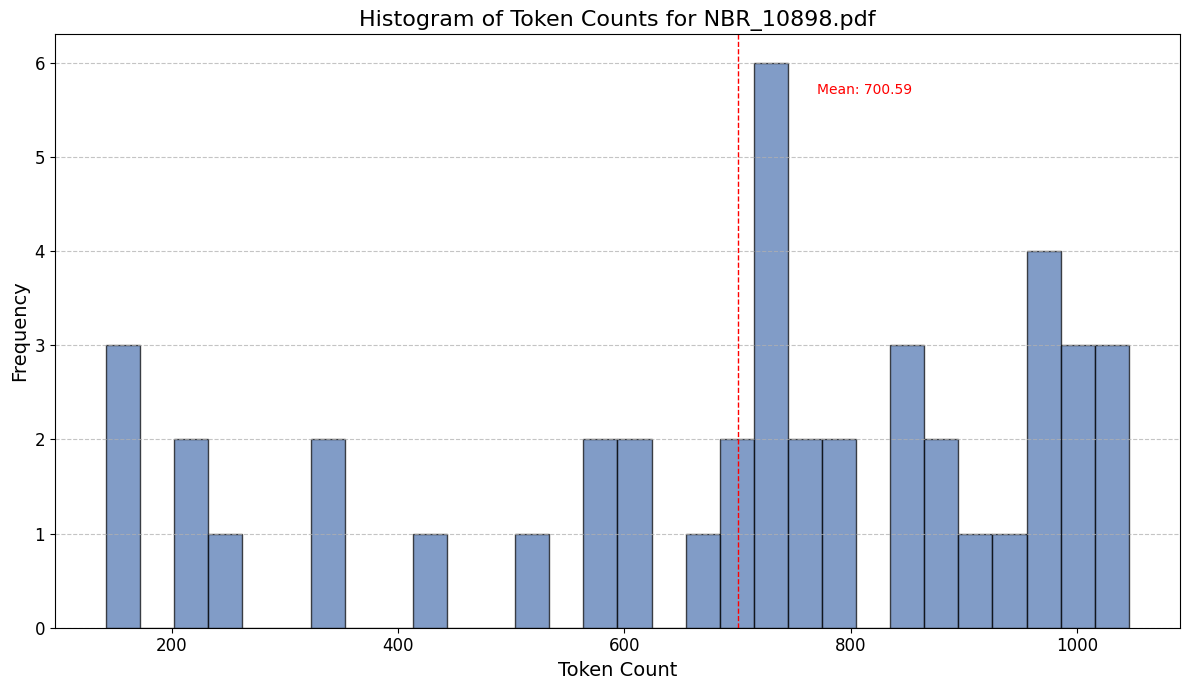

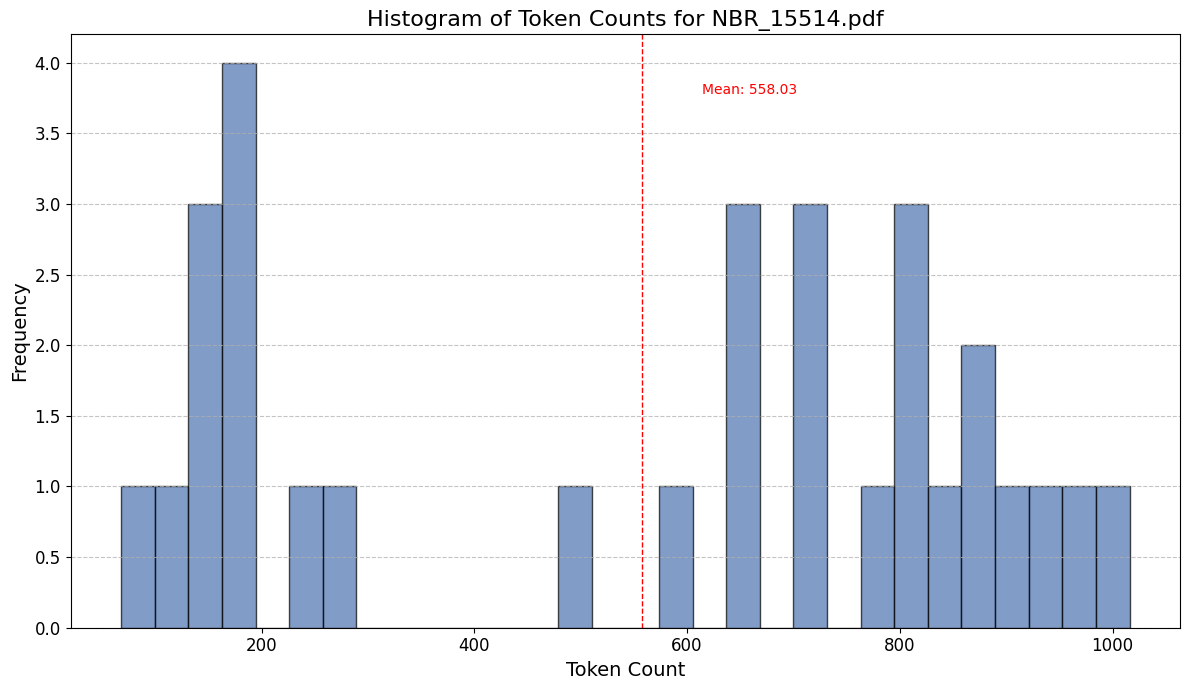

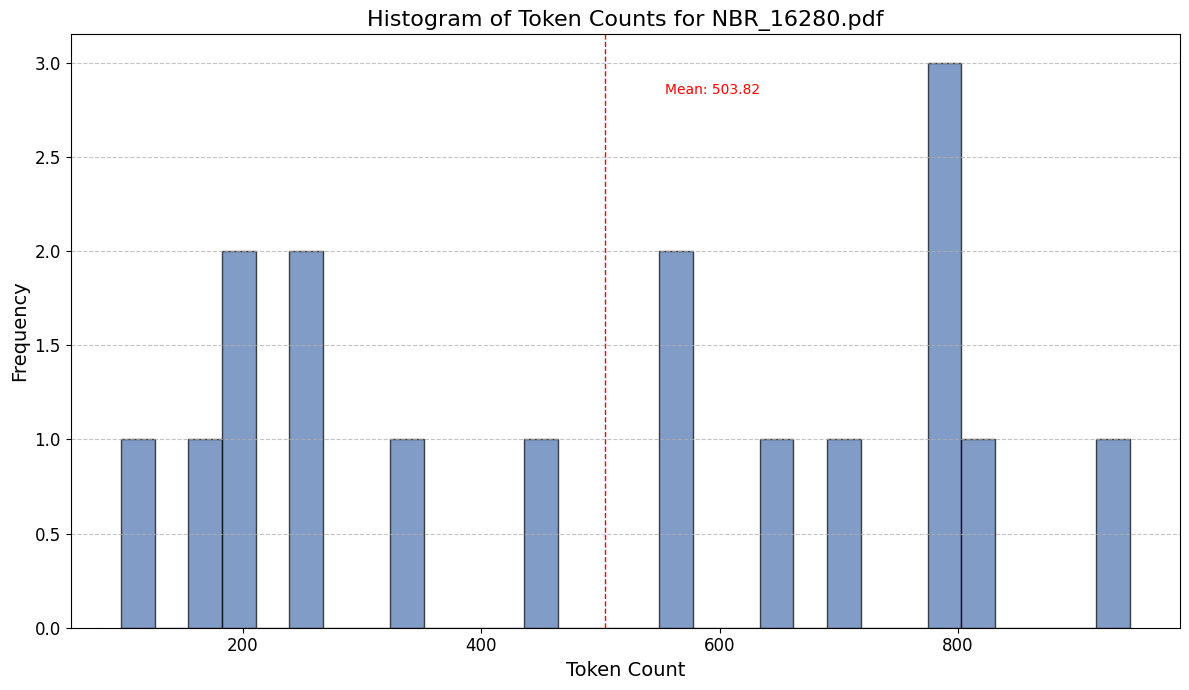

In [4]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Inicializar lista concatenada e lista para plotagem
docs = []
all_counts = []

# Concatenar conteúdo
for filename, docs_in_file in pdf_results.items():
    docs.extend(docs_in_file)
    docs_texts = [d.page_content for d in docs_in_file]

    # Calcular o número de tokens para cada documento
    counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]
    all_counts.extend(counts)

    # Plotar o histograma de contagem de tokens para cada PDF
    plt.figure(figsize=(12, 7))
    plt.hist(counts, bins=30, color="#4C72B0", edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of Token Counts for {filename}", fontsize=16)
    plt.xlabel("Token Count", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", alpha=0.75, linestyle='--')
    
    # Melhorar a exibição das legendas
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adicionar uma linha média
    mean_val = sum(counts) / len(counts)
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_val * 1.1, plt.ylim()[1] * 0.9, f'Mean: {mean_val:.2f}', color = 'red')

    # Ajustar layout
    plt.tight_layout()

    # Exibir o histograma
    plt.show()

In [5]:
docs[0]

Document(page_content='Válida a partir de ediçãoABNT NBR NORMA \nBRASILEIRA\nICS ISBN 978-85-07-\nNúmero de referência 67 páginas5419-1\nPrimeira\n22.05.2015\n22.06.2015\nProteção contra descargas atmosféricas \nParte 1: Princípios gerais\nLightning protection Part 1: General principles\n91.120.40 05501-3\nABNT NBR 5419-1:2015\n © ABNT 2015\nDocumento impresso em 29/10/2020 12:05:57, de uso exclusivo de UNIVERSIDADE DE SAO PAULO - SEF\nDocumento impresso em 29/10/2020 12:05:57, de uso exclusivo de UNIVERSIDADE DE SAO PAULO - SEF ', metadata={'source': 'app/src/database/pdf/NBR_5419_1.pdf', 'page': 0})

In [6]:
# Ordenar e reverter os documentos
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenar o conteúdo dos documentos
concatenated_content = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_content, "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context: {total_tokens}")

Num tokens in all context: 800830


## Text processing

In [7]:
len(concatenated_content)

2386237

In [8]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)

texts_split = text_splitter.split_text(concatenated_content)
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 746


In [54]:
# # Doc texts split --TESTING
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# chunk_size_tok = 2000
# text_splitter_ = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=chunk_size_tok, chunk_overlap=200
# )

# texts_split_ = text_splitter_.split_text(concatenated_content)
# print(f"Number of text splits generated: {len(texts_split_)}")

Number of text splits generated: 752


In [9]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import time

embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document")

# global_embeddings = [embd.embed_query(txt) for txt in texts_split]

# print(f"Size of the vector for the chunk 0 : {len(global_embeddings[0])}")

# Função para calcular os embeddings com tempo de espera para evitar rate limit
def generate_embeddings(texts, embd, sleep_time=1):
    """
    Generates embeddings for a list of texts using the provided embedding model.
    
    Returns:
        list: A list of generated embeddings, corresponding to the input texts.
    """
    count = 0
    embeddings = []
    for txt in texts:
        try:
            embedding = embd.embed_query(txt)
            embeddings.append(embedding)
            count+=1
            
        except Exception as e:
            print(f"Error processing {txt[:50]}: {e}")
        
        # Rate-limit processing with sleep every 10 texts
        if count %50 == 0:
            time.sleep(sleep_time) 
        
    return embeddings

# Gerar os embeddings com tempo de espera de 1 segundo entre as requisições
global_embeddings = generate_embeddings(texts_split, embd, sleep_time=1)

# Exibir o tamanho do vetor para o primeiro chunk
print(f"Size of the vector for the chunk 0 : {len(global_embeddings[0])}")

Size of the vector for the chunk 0 : 768


In [10]:
print(f"Size of the vector for the chunk 2 : {len(global_embeddings[2])}")

Size of the vector for the chunk 2 : 768


In [11]:
len(global_embeddings)

746

In [26]:
type(global_embeddings)

list

## Visualizing the clustering

In [ ]:
import sklearn
print(sklearn.show_versions())

In [14]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(embeddings: np.ndarray,
                              dim: int,
                              n_neighbors: Optional[int] = None,
                              metric: str = "cosine")-> np.ndarray:
    
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
        
    result =  umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)
    if not isinstance(result, np.ndarray):
        raise TypeError("Unexpected UMAP output type. Expected ndarray.")
    return result

[6.5131583 9.474103 ]


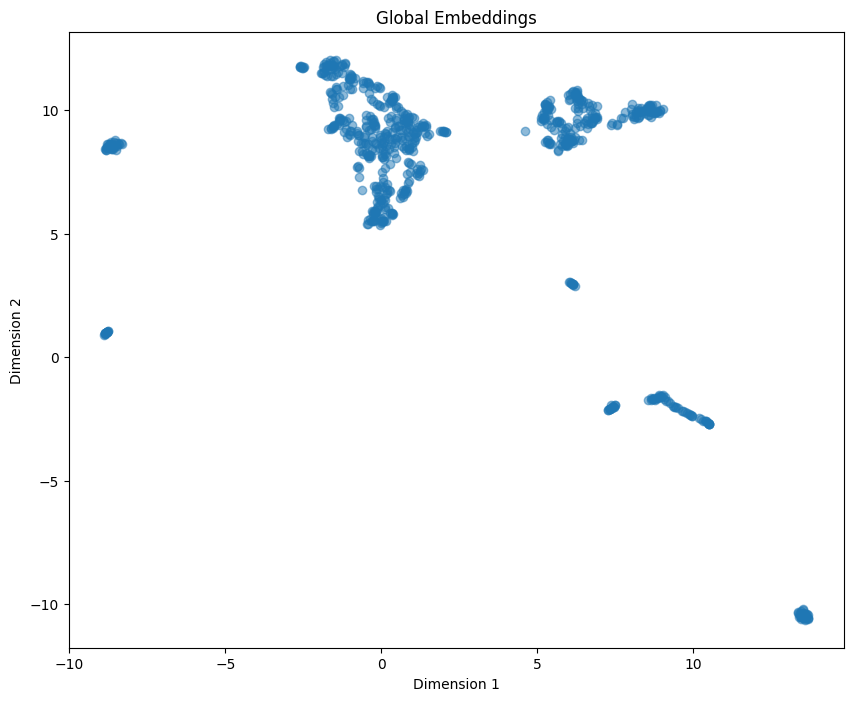

In [27]:
dim = 2

global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

print(global_embeddings_reduced[0])

plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [28]:
global_embeddings_reduced

array([[ 6.5131583 ,  9.474103  ],
       [ 5.6927342 ,  9.522502  ],
       [ 5.6108155 ,  9.536779  ],
       ...,
       [ 0.05144173,  5.510874  ],
       [ 1.1959567 ,  7.356849  ],
       [-0.46948344,  5.3862195 ]], dtype=float32)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224

def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

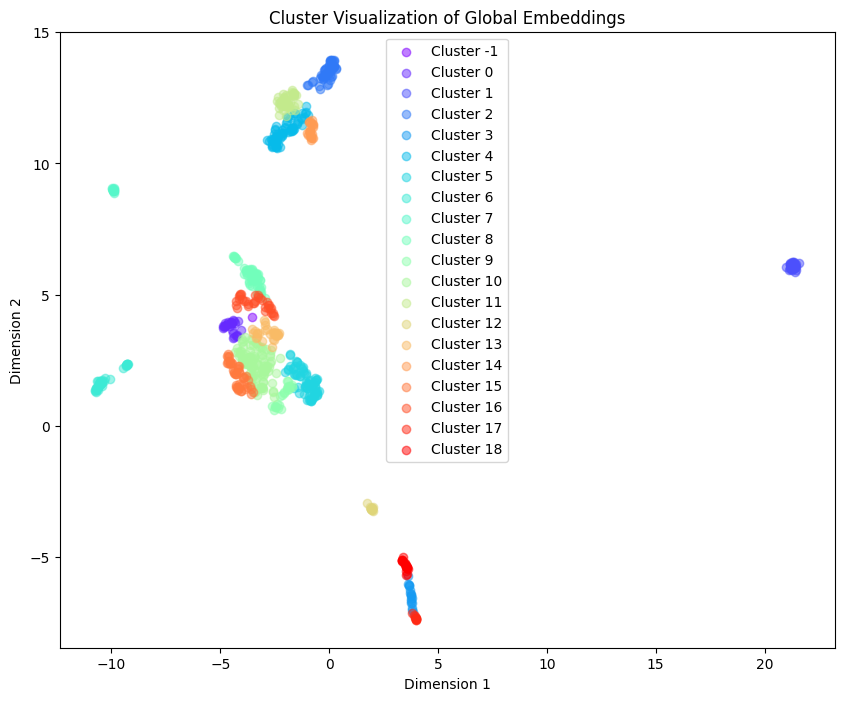

In [18]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [37]:
num_unclassified = np.sum(plot_labels == -1)
print(f"Número de pontos não classificados: {num_unclassified}")

Número de pontos não classificados: 1


In [39]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})

# Configurações do Pandas para melhor visualização
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibindo o DataFrame com um estilo mais legível
display(df.head(10))

,Text,Embedding,Cluster
0,"Bibliografia\nABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação\nA...","[6.5131583, 9.474103]",4
1,Transformado r A T B o b a C T M / TSPDA\nSubsistema de ate rrament o do edifício\natingido p...,"[5.6927342, 9.522502]",4
2,e) os serviços adicionais condutores ligados às instalações. Eles conduzem uma parcela da corren...,"[5.6108155, 9.536779]",4
3,"Caso estas premissas sejam atendidas, o equipamento está convenientemente protegido pelo DPS 1. ...","[5.8951597, 9.151551]",11
4,C.2.2 Seleção considerando a localização e a corrente da descarga atmosférica\nOs DPS devem sup...,"[5.799099, 9.279931]",4
5,"C.2.1.4 Quando o DPS é instalado no ponto de entrada da linha na estrutura, um ΔU = 1 kV/m de \...","[5.933539, 9.272251]",4
6,"Valores de probabilidades PDPS como função do NP são dados na ABNT NBR 5419-2:2015, \nTabela B....","[4.6225367, 9.140296]",4
7,Anexo C \n(informativo) \n \nSeleção e instalação de um sistema coordenado de DPS\nC.1 Introduç...,"[6.0038905, 9.339629]",4
8,B.15 Visão geral das medidas de proteção possíveis\nB.15.1 Entrada de energia\nRedes de alimen...,"[5.9941387, 8.835455]",11
9,B.13.3 Linhas metálicas\nSem interconexões apropriadas entre sistemas de aterramento de estrutu...,"[5.786118, 8.546695]",11


In [40]:
def format_cluster_texts(df: pd.DataFrame):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts
#
clustered_texts = format_cluster_texts(df)
#
clustered_texts

{4: 'Bibliografia\nABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação\nABNT NBR 13571, Haste de aterramento aço-cobreado e acessórios\nABNT NBR IEC 60079-10-1, Atmosferas explosivas – Parte 10-1: Classificação de áreas – Atmosferas \nexplosivas de gás\nABNT NBR IEC 60079-10-2, Atmosferas explosivas – Parte 10-2: Classificação de áreas – Atmosferas \nde poeiras combustíveisABNT NBR IEC 60079-14, Atmosferas explosivas – Parte 14: Projeto, seleção e montagem de \ninstalações elétricasIEC 60364-4-44, Low-voltage electrical installations – Part 4-44: Protection for safety – Protection \nagainst voltage disturbances and electromagnetic disturbancesIEC 60364-5-53, Electrical installations of buildings – Part 5-53: Selection and erection of electrical \nequipment – Isolation, switching and controlIEC 61643-11, Low-voltage surge protective devices – Part 11: Surge protective devices connected  \nto low-voltage power systems –Requirements and test methodsIEC 62305 (a

In [45]:
import pandas as pd

def format_cluster_texts(df: pd.DataFrame) -> pd.DataFrame:
    clustered_texts = []
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts.append({
            'Cluster': cluster,
            'Texts': " --- ".join(cluster_texts)
        })
    return pd.DataFrame(clustered_texts)

# Formatação e visualização dos textos agrupados por cluster
clustered_texts_df = format_cluster_texts(df)

# Configurações do Pandas para melhor visualização
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibindo o DataFrame com os textos agrupados por cluster
display(clustered_texts_df)

,Cluster,Texts
0,4,"Bibliografia\nABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação\nA..."
1,11,"Caso estas premissas sejam atendidas, o equipamento está convenientemente protegido pelo DPS 1. ..."
2,2,Anexo F \n(informativo) \n \nDensidade de descargas atmosféricas NG\nF.1 Considerações \tsobre\...
3,14,"falha de um DPS de óxido metálico é relacionada com as suas características mais fracas, sendo, ..."
4,6,12 NBR 5413/1992\n- enchimento de fornos:\n . poço de resíduos.................... 150 - 200 - ...
5,10,ABNT NBR 5410:2004\nABNT NBR 5410:2004\n© ABNT 2004\n  \nTodos os direitos reservados\n209\n209...
6,15,ABNT NBR 5410:2004\nABNT NBR 5410:2004\n© ABNT 2004\n  \nTodos os direitos reservados\n203\n203...
7,13,ABNT NBR 5410:2004\nABNT NBR 5410:2004\n© ABNT 2004\n  \nTodos os direitos reservados\n197\n197...
8,0,ABNT NBR 5410:2004\nABNT NBR 5410:2004\n188\n188\n© ABNT 2004\n  \nTodos os direitos reservados...
9,3,2\n I\n m\n p\n r\n e\n s\n s\n o\n :\n 2\n 2\n /\n 0\n 1\n /\n 2\n 0\...


In [47]:
clustered_texts_df.columns

Index(['Cluster', 'Texts'], dtype='object')

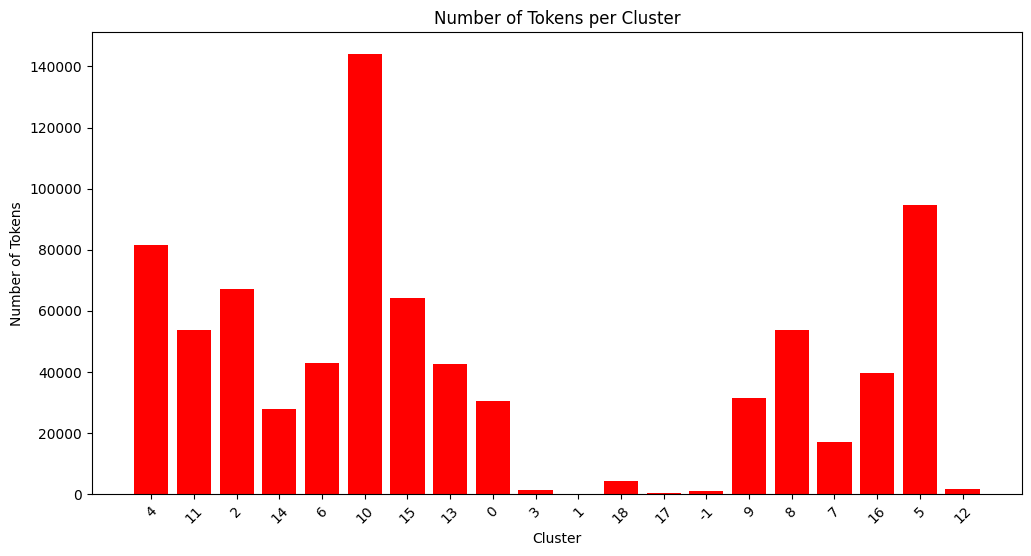

In [50]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

clustered_texts_df['NumTokens'] = clustered_texts_df['Texts'].apply(lambda x: num_tokens_from_string(x, 'cl100k_base'))

# Preparar os dados para o gráfico
cluster_sizes = clustered_texts_df[['Cluster', 'NumTokens']]

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(cluster_sizes['Cluster'].astype(str), cluster_sizes['NumTokens'], color='red')
plt.xlabel('Cluster')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens per Cluster')
plt.xticks(rotation=45)
plt.show()

## Summarizing the clusters

In [55]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document")
model = GoogleGenerativeAI(model="gemini-pro", temperature=0, top_p=0.85)

template = """Você é um assistente para criar um resumo detalhado da entrada de texto fornecida.
Texto:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [62]:
import time

summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary
    
    print(f"Sleeping for 5 seconds")
    time.sleep(5)

InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting

In [ ]:
summaries

In [ ]:
embedded_summaries = [gemini_embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [ ]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [ ]:
clustered_summaries

In [ ]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [ ]:
final_summaries

In [ ]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

## Add to vectorstore

In [21]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document")

In [ ]:
from langchain_community.vectorstores import Chroma

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=gemini_embeddings)

In [ ]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 4)

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

## RAG Pipeline

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAI


model = GoogleGenerativeAI(model="gemini-pro", temperature=0, top_p=0.85)

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")